In [31]:
#%% 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from graspy.datasets import load_drosophila_left
from graspy.models import DCSBEstimator, RDPGEstimator, SBEstimator
from graspy.plot import heatmap, pairplot
from graspy.simulations import p_from_latent, sample_edges
from graspy.utils import binarize, is_fully_connected

# plotting stuff
sns.set_context("talk", font_scale=1)
plt.style.use("seaborn-white")
sns.set_palette("Set1")
savefig = False


def run_mses(adj, estimator, rangelist, kws):
    mse = np.zeros(len(rangelist))
    p_mse = np.zeros(len(rangelist))
    n_params = np.zeros(len(rangelist))
    for i, n in enumerate(rangelist):
        if estimator == "SBM":
            e = SBEstimator(min_comm=n, max_comm=n, **kws)
        elif estimator == "RDPG":
            e = RDPGEstimator(n_components=n, **kws)
        elif estimator == "DCSBM":
            e = DCSBEstimator(min_comm=n, max_comm=n, **kws)
        else:
            raise TypeError()
        e.fit(adj)
        mse[i] = e.mse(adj)
        p_mse[i] = e.mse(adj) + e._n_parameters() * np.log(adj.size)
        n_params[i] = e._n_parameters()
    return np.stack((mse, n_params), axis=1), np.stack((p_mse, n_params), axis=1)

Latent point


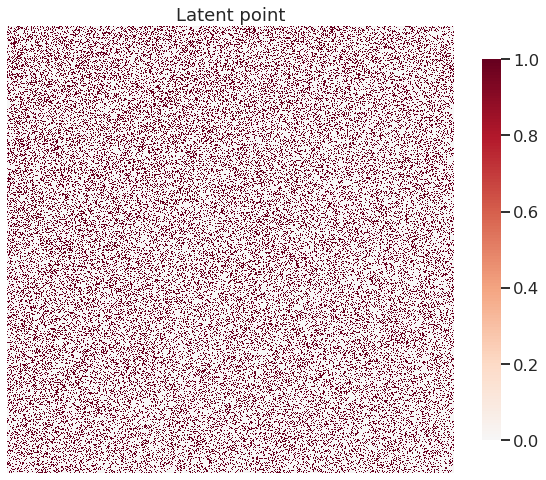

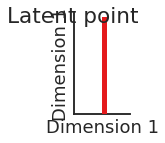

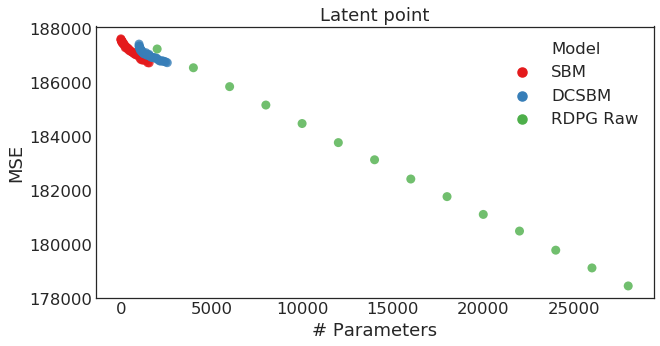

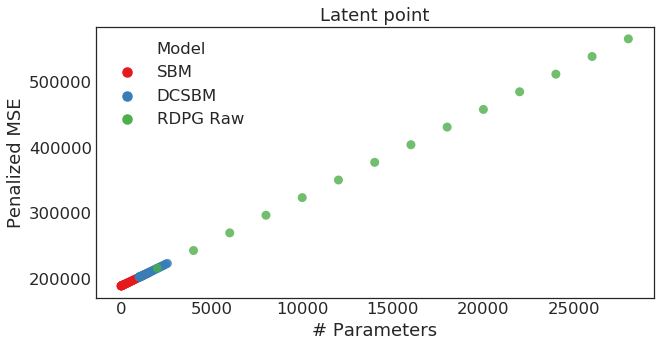

Latent line - uniform


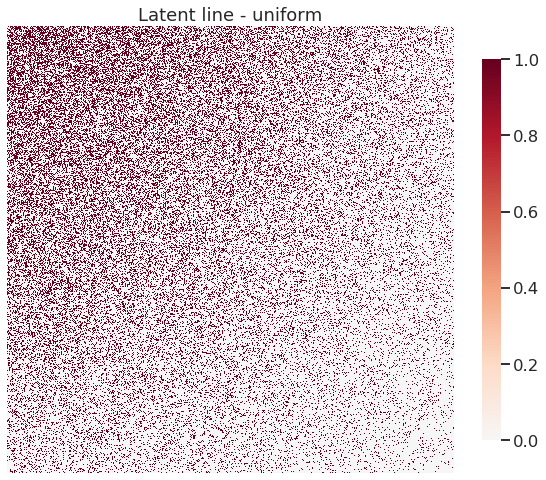

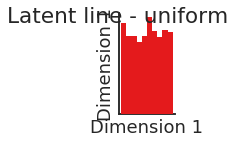

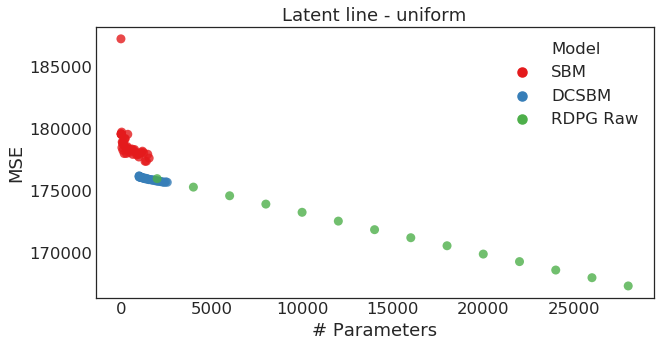

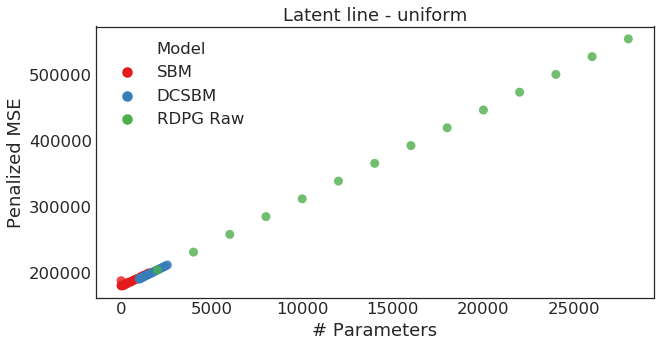

Latent line - gaussian


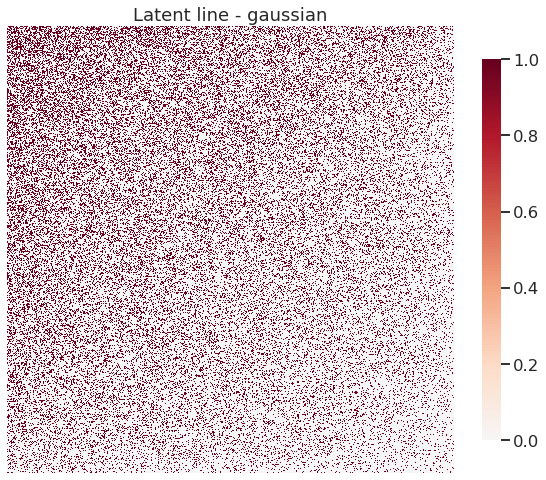

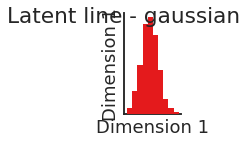

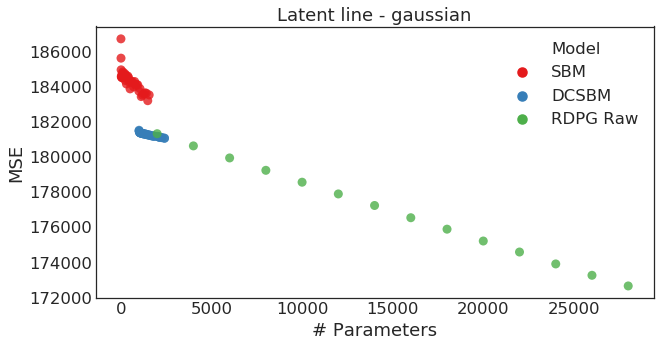

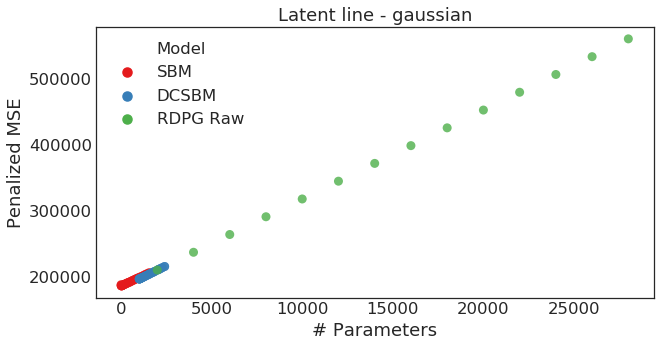

Directed latent lines - same uniform


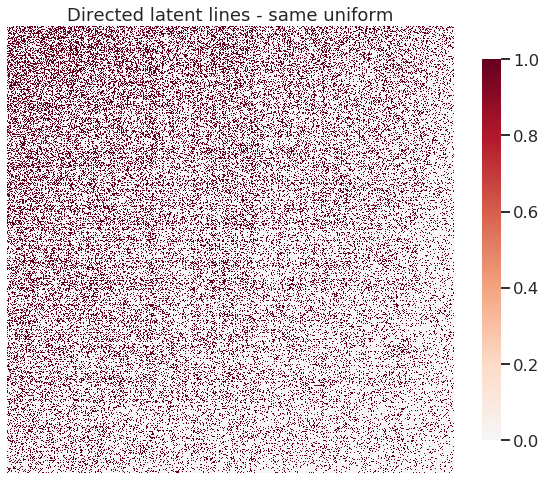

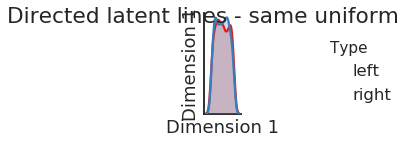

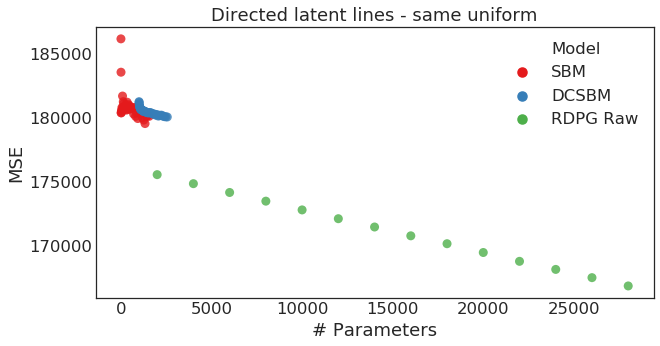

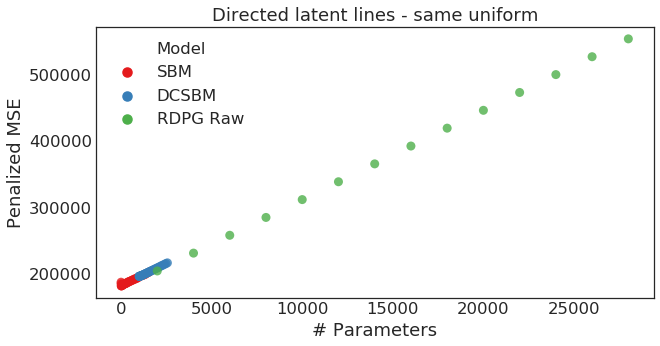

Directed latent lines - diff uniform


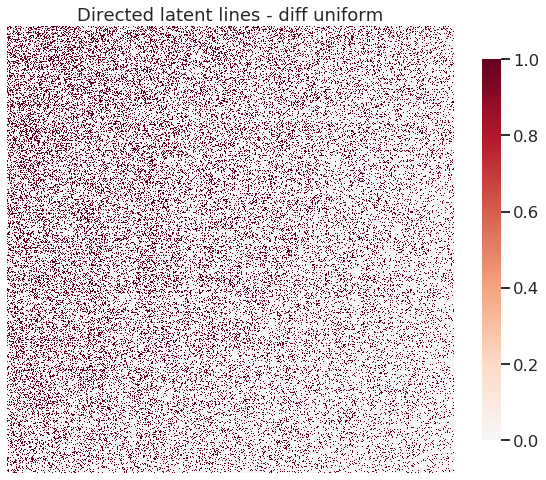

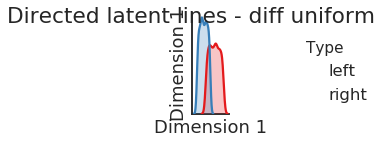

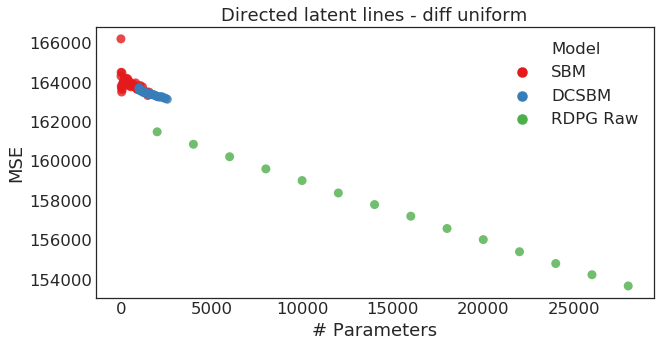

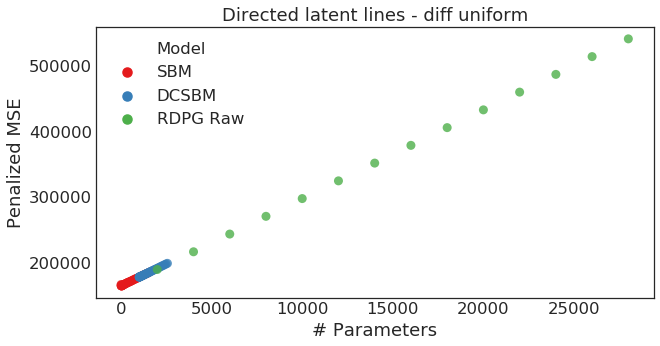

Directed latent lines - diff Gauss.


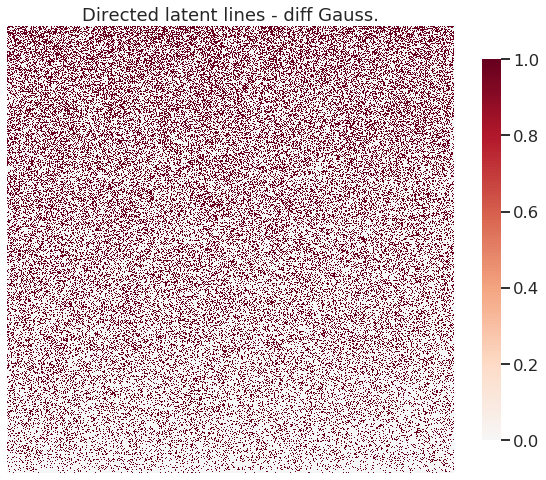

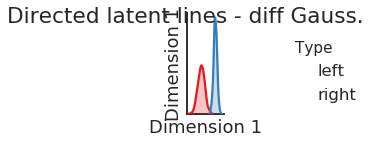

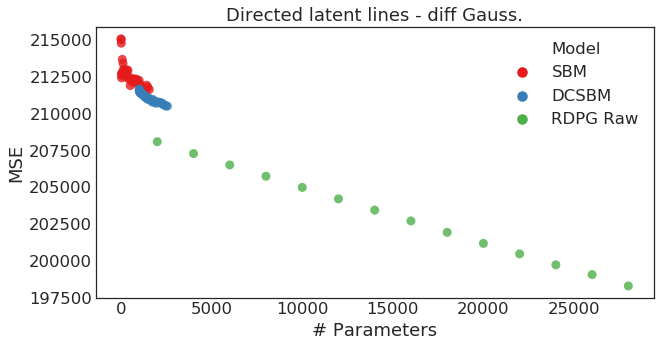

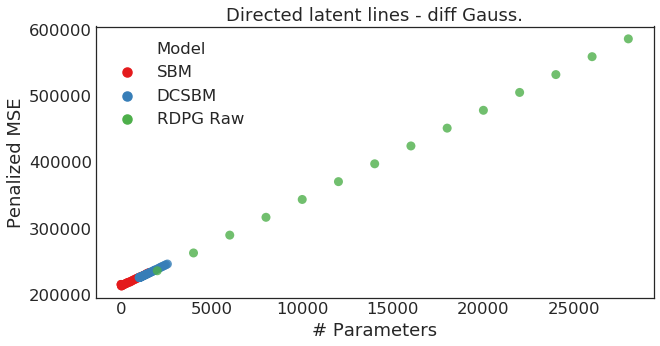

SBM - 2 block


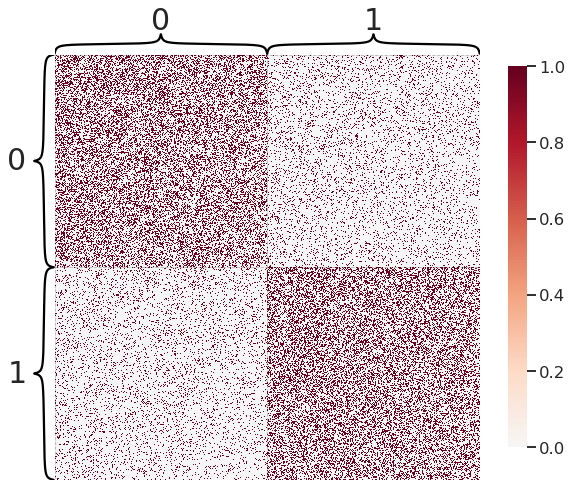

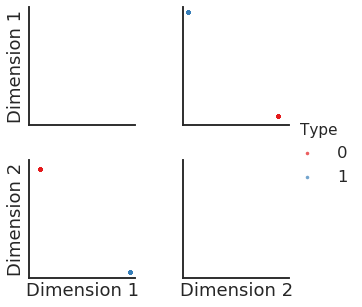

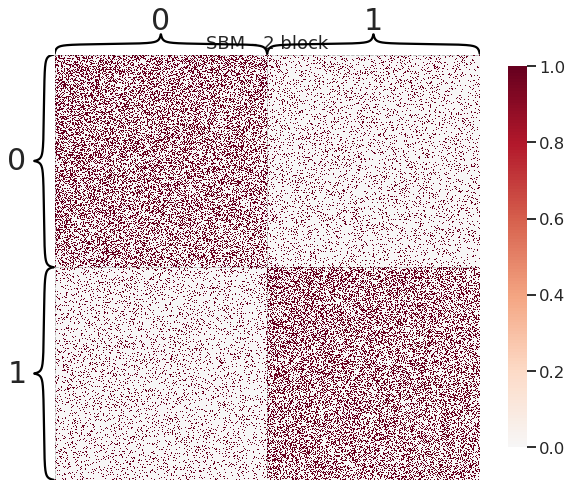

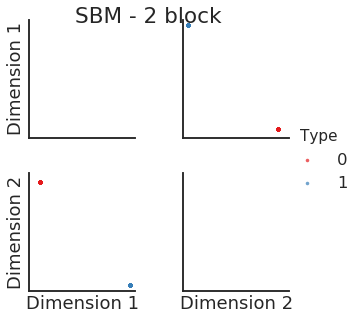

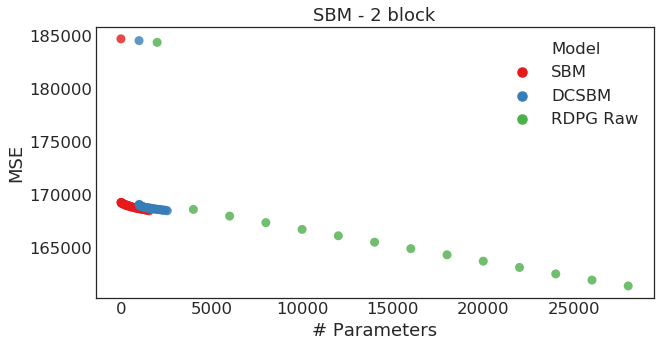

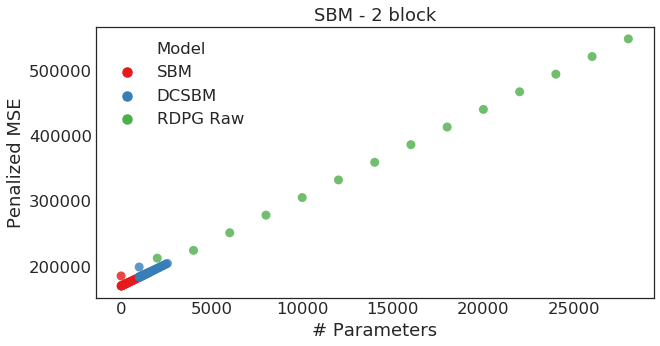

DCSBM - 2 line uniform


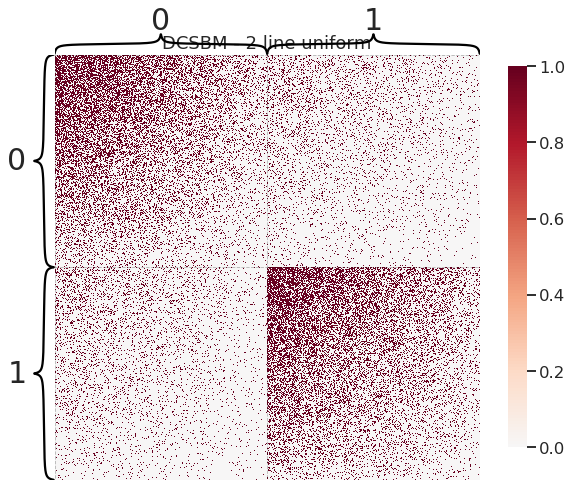

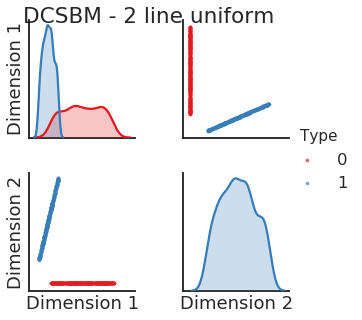

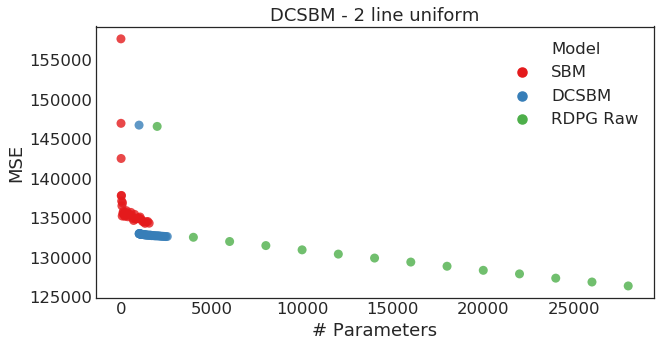

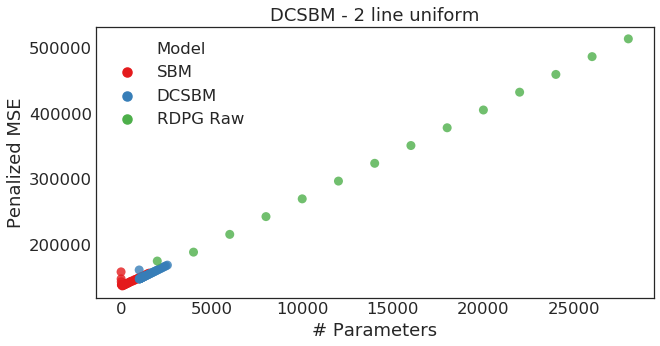

DCSBM - 2 line beta


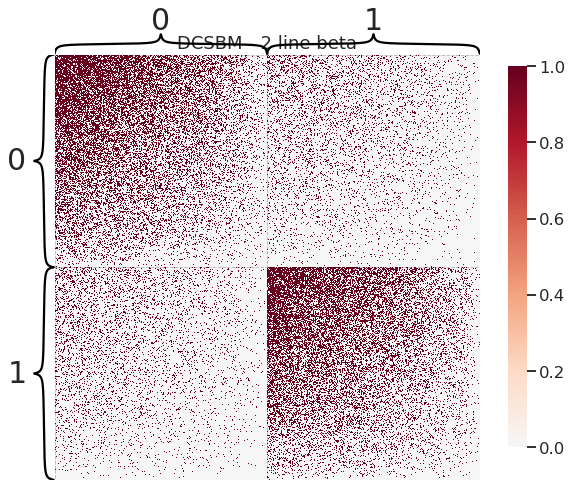

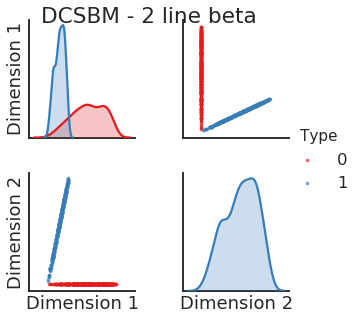

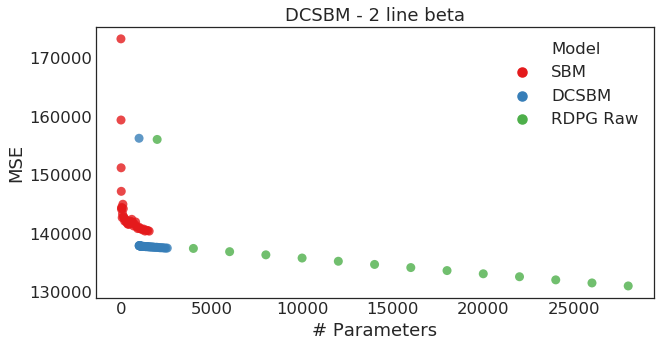

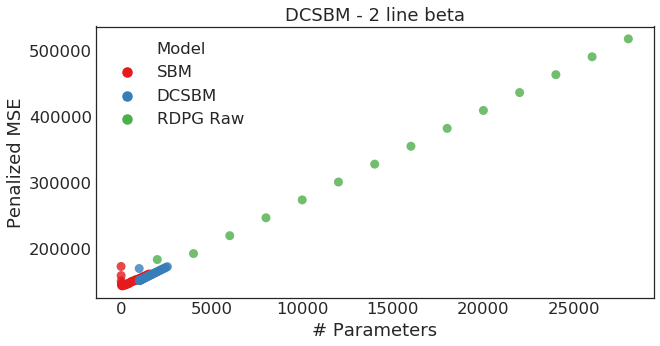

In [33]:
#%% simulated data
p_kwargs = {}
sample_kwargs = {"directed":True}
n_verts = 1000
show_graphs = True
show_latent = True
names = []
graph_sims = []

def get_graph(latent, labels=None, title=None):
    if type(latent) is tuple:
        left_latent = latent[0]
        right_latent = latent[1]
    else:
        left_latent = latent
        right_latent = None
    true_P = p_from_latent(left_latent, right_latent, **p_kwargs)
    graph = sample_edges(true_P, **sample_kwargs)
    if not is_fully_connected(graph):
        raise ValueError("unconnected graph")
    if show_graphs:
        heatmap(graph, inner_hier_labels=labels, title=title)
    if show_latent:
        if right_latent is not None:
            labels = np.array(
                len(left_latent) * ["left"] + len(right_latent) * ["right"]
            )
            latent = np.concatenate((left_latent, right_latent), axis=0)
            pairplot(latent, labels=labels, title=title)
        else:
            pairplot(left_latent, labels=labels, title=title)
    return graph


def evaluate_models(adj, title, labels=None):
    mse_exps = []
    pmse_exps = []
    names = []
    print(title)

    # SBM NORMAL ######
    name = "SBM"
    max_comm = 40
    comm_range = list(range(1, max_comm))
    sb_kws = dict(directed=True, loops=False)

    sb_mse, sb_pmse = run_mses(adj, "SBM", comm_range, sb_kws)
    mse_exps.append(sb_mse)
    pmse_exps.append(sb_pmse)
    names.append(name)

    # DCSBM NORMAL ######
    name = "DCSBM"
    max_comm = 40
    comm_range = list(range(1, max_comm))
    dcsb_kws = dict(directed=True, loops=False, degree_directed=False)

    dcsb_mse, dcsb_pmse = run_mses(adj, "DCSBM", comm_range, dcsb_kws)
    mse_exps.append(dcsb_mse)
    pmse_exps.append(dcsb_pmse)
    names.append(name)

    # RDPG RAW ######
    name = "RDPG Raw"
    max_components = 15
    rdpg_kws = dict(loops=False, diag_aug_weight=0, plus_c_weight=0)
    comp_range = list(range(1, max_components))

    rdpg_raw_mse, rdpg_raw_pmse = run_mses(adj, "RDPG", comp_range, rdpg_kws)
    mse_exps.append(rdpg_raw_mse)
    pmse_exps.append(rdpg_raw_pmse)
    names.append(name)

    #%% Plot ######
    mse_data = np.concatenate(mse_exps, axis=0)

    label_vecs = []
    for e, n in zip(mse_exps, names):
        label_vecs.append(np.array(e.shape[0] * [n]))
    labels = np.concatenate(label_vecs)

    plot_df = pd.DataFrame(data=mse_data, columns=("MSE", "# Parameters"))
    plot_df["Model"] = labels
    plt.figure(figsize=(10, 5))
    sns.scatterplot(
        data=plot_df, x="# Parameters", y="MSE", hue="Model", linewidth=0, alpha=0.8
    )
    plt.title(title)
    plt.show()
    # if savefig:
    #     plt.savefig(
    #         "graph_models/drosophila_experiments/figs/model_comparison_mse.pdf",
    #         format="pdf",
    #         facecolor="w",
    #     )

    # Second plot

    pmse_data = np.concatenate(pmse_exps, axis=0)

    plot_df = pd.DataFrame(data=pmse_data, columns=("Penalized MSE", "# Parameters"))
    plot_df["Model"] = labels
    plt.figure(figsize=(10, 5))
    sns.scatterplot(
        data=plot_df,
        x="# Parameters",
        y="Penalized MSE",
        hue="Model",
        linewidth=0,
        alpha=0.8,
    )
    plt.title(title)
    plt.show()
    # if savefig:
    #     plt.savefig(
    #         "graph_models/drosophila_experiments/figs/model_comparison_pmse.pdf",
    #         format="pdf",
    #         facecolor="w",
    #     )


# for graph, name in zip(graph_sims[:2], names[:2]):
#     evaluate_models(graph, name)


inds = np.array(int(n_verts / 2) * [0] + int(n_verts / 2) * [1])

# Single point in latent space
# this should be an ER model
latent = np.array(n_verts * [0.5])
latent = latent[:, np.newaxis]  # to make it n x d
names.append("Latent point")
graph = get_graph(latent, title=names[-1])
graph_sims.append(graph)
evaluate_models(graph_sims[-1], names[-1])

# Line in 1d
# should be a degree corrected ER
latent = np.random.uniform(0.25, 0.75, n_verts)
latent = latent[:, np.newaxis]
names.append("Latent line - uniform")
graph = get_graph(latent, title=names[-1])
graph_sims.append(graph)
evaluate_models(graph_sims[-1], names[-1])


# Line in 1d, but gaussian
latent = np.random.normal(0.5, 0.1, n_verts)
latent = latent[:, np.newaxis]
names.append("Latent line - gaussian")
graph = get_graph(latent, title=names[-1])
graph_sims.append(graph)
evaluate_models(graph_sims[-1], names[-1])


# directed latent lines
left_latent = np.random.uniform(0.25, 0.75, n_verts)
left_latent = left_latent[:, np.newaxis]
right_latent = np.random.uniform(0.25, 0.75, n_verts)
right_latent = right_latent[:, np.newaxis]
latent = (left_latent, right_latent)
names.append("Directed latent lines - same uniform")
graph = get_graph(latent, title=names[-1])
graph_sims.append(graph)
evaluate_models(graph_sims[-1], names[-1])


# directed latent lines, different uniform
left_latent = np.random.uniform(0.4, 0.8, n_verts)
left_latent = left_latent[:, np.newaxis]
right_latent = np.random.uniform(0.2, 0.5, n_verts)
right_latent = right_latent[:, np.newaxis]
latent = (left_latent, right_latent)
names.append("Directed latent lines - diff uniform")
graph = get_graph(latent, title=names[-1])
graph_sims.append(graph)
evaluate_models(graph_sims[-1], names[-1])


# directed latent lines, different gaussian
left_latent = np.random.normal(0.4, 0.1, n_verts)
left_latent = left_latent[:, np.newaxis]
right_latent = np.random.normal(0.8, 0.05, n_verts)
right_latent = right_latent[:, np.newaxis]
latent = (left_latent, right_latent)
names.append("Directed latent lines - diff Gauss.")
graph = get_graph(latent, title=names[-1])
graph_sims.append(graph)
evaluate_models(graph_sims[-1], names[-1])


# sbm simple, 2 block
point1 = [0.1, 0.6]
point2 = [0.6, 0.1]
points = np.array([point1, point2])
latent = np.array(points[inds])
names.append("SBM - 2 block")
graph = get_graph(latent, title=names[-1], labels=inds)
graph_sims.append(graph)
evaluate_models(graph_sims[-1], names[-1])


# dcsbm, 2 line, uniform
thetas = np.array([0 * np.pi, 0.4 * np.pi])
distances = np.random.uniform(0.2, 0.9, n_verts)
vec1 = np.array([np.cos(thetas[0]), np.sin(thetas[0])])
vec2 = np.array([np.cos(thetas[1]), np.sin(thetas[1])])
latent1 = np.multiply(distances[: int(n_verts / 2)][:, np.newaxis], vec1[np.newaxis, :])
latent2 = np.multiply(distances[int(n_verts / 2) :][:, np.newaxis], vec2[np.newaxis, :])
latent = np.concatenate((latent1, latent2), axis=0)
names.append("DCSBM - 2 line uniform")
graph = get_graph(latent, title=names[-1], labels=inds)
graph_sims.append(graph)
evaluate_models(graph_sims[-1], names[-1])


# dcsbm, 2 line, beta
thetas = np.array([0 * np.pi, 0.4 * np.pi])
distances = np.random.beta(2, 1.5, n_verts)
vec1 = np.array([np.cos(thetas[0]), np.sin(thetas[0])])
vec2 = np.array([np.cos(thetas[1]), np.sin(thetas[1])])
latent1 = np.multiply(distances[: int(n_verts / 2)][:, np.newaxis], vec1[np.newaxis, :])
latent2 = np.multiply(distances[int(n_verts / 2) :][:, np.newaxis], vec2[np.newaxis, :])
latent = np.concatenate((latent1, latent2), axis=0)
names.append("DCSBM - 2 line beta")
graph = get_graph(latent, title=names[-1], labels=inds)
graph_sims.append(graph)
evaluate_models(graph_sims[-1], names[-1])

#%%